# Exercise 2.3 - SVD + NN

Dimensionality reduction and prediciton of next states by means of a neural network, for a Reaction-Diffusion model

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import scipy.io as sio
import os
import tensorflow as tf
import tensorflow.keras as K

In [2]:
# Loading data

cwd = os.getcwd()
data = sio.loadmat(os.path.join(cwd,"Datasets","reaction_diffusion_big.mat"))

t = data['t'][:,0]
x = data['x'][0,:]
y = data['y'][0,:]
u = data['u']
v = data['v']

del data

In [3]:
# SVD
# Dobbiamo normalizzare? non ho chiarissio questo punto

# Rehsape u, v into vectors; now every "image" (time snapshot) is a vector
n_pixels = len(x)*len(y)
u_res = np.reshape(u,(n_pixels , len(t)))
v_res = np.reshape(v, (n_pixels , len(t)))
uv_res = np.concatenate((u_res, v_res), axis=0)

[U, S, V] = np.linalg.svd(uv_res, full_matrices=False)

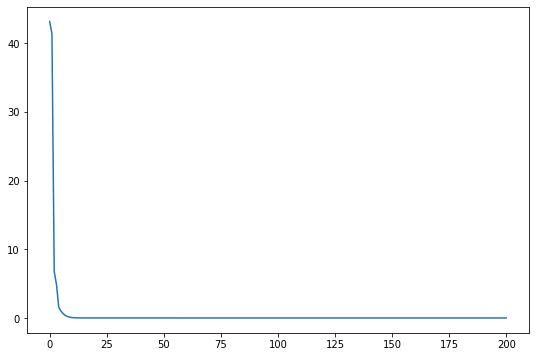

In [4]:
# Let's undertand what happened in the SVD


#s_values = np.diagonal(S)
s_values = S/np.sum(S)*100

plt.figure(figsize=(9, 6), facecolor="white")
plt.plot(s_values)

# T take the values superior to 0.01 %, we take the first 12 elements
r = 12
U_r = U[:,:r]
V_r = V[:r,:r]
S_r = S[:r]

In [5]:
# Projection and NN training

z = np.matmul(np.transpose(U_r),uv_res)
z = np.transpose(z)


# x_train = z[:-1,:]
# y_train = z[1:,:]

# # Model definition
# x_in = K.Input(shape=(z.shape[-1],))
# y = K.layers.Dense(10, activation="relu")(x_in)
# y = K.layers.Dense(6, activation="relu")(y)
# y = K.layers.Dense(10, activation="relu")(y)
# y = K.layers.Dense(z.shape[-1], activation="linear")(y)
# model = K.Model(x_in, y)

# # Model .compile
# model.compile(
#     optimizer="adam",
#     loss="mean_squared_error",
#     metrics="mean_absolute_error",
# )

# # fitting
# train_history = model.fit(
#     x = x_train,
#     y = y_train,
#     shuffle=True,
#     epochs=2000,
#     verbose=0,
#     use_multiprocessing=True,
#     workers=8,
#     batch_size = 16
# )

# model.save(os.path.join("RD_model1"))



In [6]:
# Make predicitons on  the dataset based on the initial conditions
# We just project the initial conditions into the reduced space

# Projection of the initial conditions
uv_0 = uv_res[:,0]
z0 = np.matmul(np.transpose(U_r),uv_0)

#Prediciton through neural network
NN = K.models.load_model(os.path.join(cwd,"RD_model1"))
n_timesteps = len(t)
z_pred = np.zeros((n_timesteps, r))
z_pred[0,:] = z0 
for step in range(n_timesteps-1):
    pred = NN.predict(z_pred[step,:].reshape((1, 12,)))
    z_pred[step+1,:] = pred
    
# Scale back to the original dimension ( (524288,12)X(12x201))
uv_res_back = np.matmul(U_r, np.transpose(z_pred))
n_pixels = len(x)*len(y)
u_back = uv_res_back[:n_pixels,:]
u_back.resize((len(x), len(y), len(t)),)
v_back = uv_res_back[n_pixels:,:]
v_back.resize((len(x),len(y),len(t)),)

2022-07-16 08:56:43.600861: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-16 08:56:43.628166: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-16 08:56:43.628442: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-16 08:56:43.634839: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

1/1 [==============================] - 0s 14ms/step


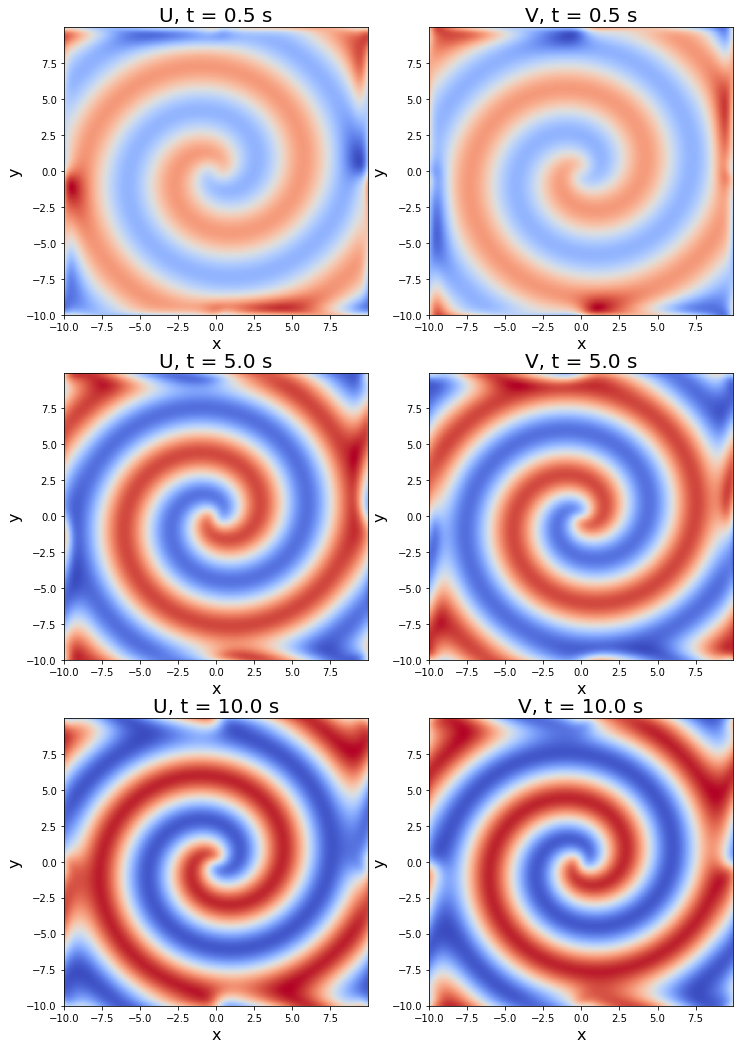

In [12]:
# Let's plot the predicitons at 3 different steps

plt_steps = [10, 100, 200]

plt.figure(figsize=(12, 18), facecolor="white")
#xx, yy = np.meshgrid(np.arange(n)*dx,np.arange(n)*dy)
k = 1
for step in plt_steps:

    # Plot U
    plt.subplot(3, 2, k)
    plt.pcolor(x,y,u_back[:,:,step],cmap='coolwarm')
    plt.title(f'U, t = {t[step]} s', fontsize = 20)
    plt.xlabel('x', fontsize = 16)
    plt.ylabel('y', fontsize = 16)

    # Plot V
    plt.subplot(3, 2, k+1)
    plt.pcolor(x,y,v_back[:,:,step],cmap='coolwarm')
    plt.title(f'V, t = {t[step]} s', fontsize = 20)
    plt.xlabel('x', fontsize = 16)
    plt.ylabel('y', fontsize = 16)
    
    k += 2


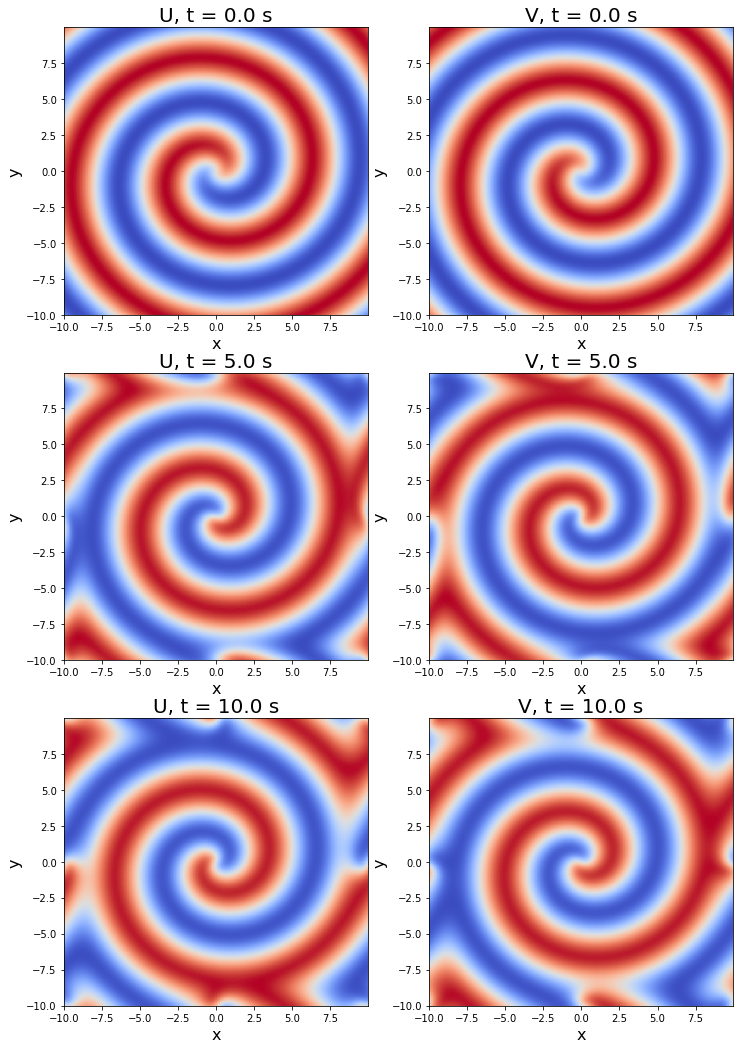

In [8]:
# .. And confront them with the original dataset:

plt.figure(figsize=(12, 18), facecolor="white")
k = 1
for step in plt_steps:

    # Plot U
    plt.subplot(3, 2, k)
    plt.pcolor(x,y,u[:,:,step],cmap='coolwarm')
    plt.title(f'U, t = {t[step]} s', fontsize = 20)
    plt.xlabel('x', fontsize = 16)
    plt.ylabel('y', fontsize = 16)

    # Plot V
    plt.subplot(3, 2, k+1)
    plt.pcolor(x,y,v[:,:,step],cmap='coolwarm')
    plt.title(f'V, t = {t[step]} s', fontsize = 20)
    plt.xlabel('x', fontsize = 16)
    plt.ylabel('y', fontsize = 16)
    
    k += 2

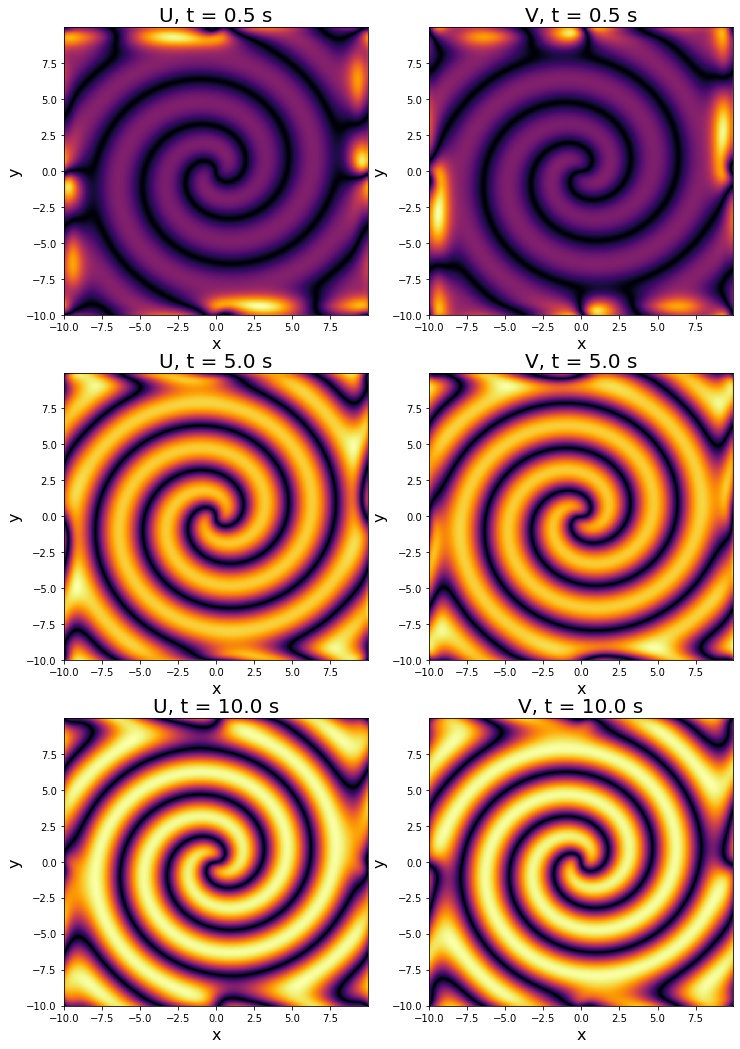

In [19]:
# Let's plot the absolute difference:

plt.figure(figsize=(12, 18), facecolor="white")

k = 1
for step in plt_steps:

    error_u = np.abs(u[:,:,step] - u_back[:,:,step])
    error_v = np.abs(v[:,:,step] - v_back[:,:,step])

    # Plot U
    plt.subplot(3, 2,k)
    plt.pcolor(x,y,error_u,cmap='inferno')
    plt.title(f'U, t = {t[step]} s', fontsize = 20)
    plt.xlabel('x', fontsize = 16)
    plt.ylabel('y', fontsize = 16)

    # Plot V
    plt.subplot(3, 2, k+1)
    plt.pcolor(x,y,error_v,cmap='inferno')
    plt.title(f'V, t = {t[step]} s', fontsize = 20)
    plt.xlabel('x', fontsize = 16)
    plt.ylabel('y', fontsize = 16)

    k = k+2

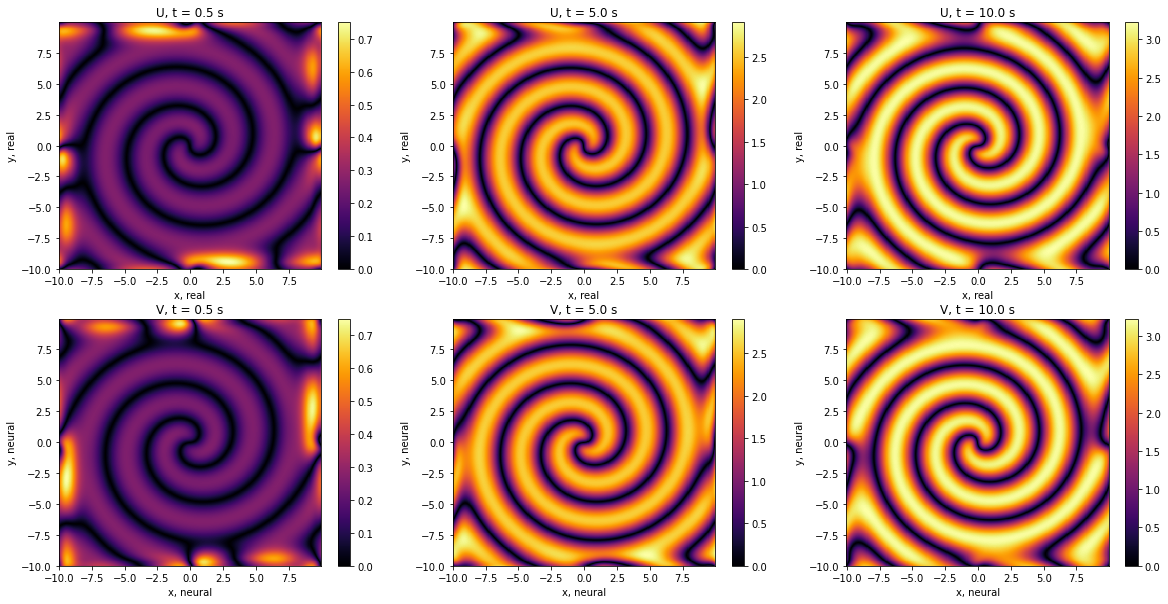

In [35]:
# Let's plot the absolute difference:

cwd = os.getcwd()
savefig = os.path.join(cwd, 'Images')


# Plot U
fig, axs = plt.subplots(2, 3, figsize=(20, 10), facecolor="white")

for idx, step in enumerate(plt_steps):

    error_u = np.abs(u[:,:,step] - u_back[:,:,step])
    error_v = np.abs(v[:,:,step] - v_back[:,:,step])

    ax = axs[0, idx]
    c = ax.pcolor(x,y,error_u,cmap='inferno')
    fig.colorbar(c, ax=ax)
    ax.set(title=f'U, t = {t[step]} s', xlabel='x, real', ylabel='y, real')

    ax = axs[1, idx]
    c = ax.pcolor(x,y,error_v,cmap='inferno')
    fig.colorbar(c, ax=ax)
    ax.set(title=f'V, t = {t[step]} s', xlabel='x, neural', ylabel='y, neural')

plt.savefig(os.path.join(savefig, "RD_relaVSneural"))